In [15]:
# AUTOENCODER ANOMALY DETECTION
# WITH SYNTHETIC LABELS (0/1)
# -------------------------------

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [17]:
# 1. LOAD THE DATASET
# -------------------------------------------------------
dataset = pd.read_csv("C:/Users/Sayali/Downloads/Credit Card Customer Data - Credit Card Customer Data.csv")


In [18]:
print("\nColumns:")
print(dataset.columns)


Columns:
Index(['Sl_No', 'Customer Key', 'Avg_Credit_Limit', 'Total_Credit_Cards',
       'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'],
      dtype='object')


In [19]:
# 2. PREPROCESS – REMOVE NON-USEFUL COLUMNS
# -------------------------------------------------------
X = dataset.drop(["Sl_No", "Customer Key"], axis=1)

print("\nHead of usable data:")
print(X.head())


Head of usable data:
   Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0            100000                   2                  1   
1             50000                   3                  0   
2             50000                   7                  1   
3             30000                   5                  1   
4            100000                   6                  0   

   Total_visits_online  Total_calls_made  
0                    1                 0  
1                   10                 9  
2                    3                 4  
3                    1                 4  
4                   12                 3  


In [23]:
# 3. CREATE SYNTHETIC CLASS LABELS (5% anomalies)
# -------------------------------------------------------
np.random.seed(42)
dataset["Class"] = 0  # normal

# randomly assign 5% as anomalies
anomaly_indices = np.random.choice(dataset.index, size=int(0.05 * len(dataset)), replace=False)
dataset.loc[anomaly_indices, "Class"] = 1

y = dataset["Class"]

print("\nSynthetic label distribution:")
print(dataset["Class"].value_counts())


Synthetic label distribution:
Class
0    627
1     33
Name: count, dtype: int64


In [24]:
# 5. TRAIN-TEST SPLIT
# -------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Only NORMAL transactions (Class = 0) used for training
X_train_normal = X_train[y_train == 0]

In [26]:
# 6. BUILD AUTOENCODER MODEL
# -------------------------------------------------------
input_dim = X_train_normal.shape[1]

encoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu")
])

decoder = models.Sequential([
    layers.Input(shape=(8,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(input_dim, activation="linear")
])
autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(
    loss="mean_squared_error",
    optimizer="adam"
)

In [27]:
# 7. TRAIN AUTOENCODER (ONLY NORMAL DATA)
# -------------------------------------------------------
print("\nTraining Autoencoder...")
autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=10,
    batch_size=64,
    shuffle=True
)


Training Autoencoder...
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9394
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8979  
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7935 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7702 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6834 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5995 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4874 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3784 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3053 
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2607 


In [28]:
# 8. RECONSTRUCTION ERROR ON TEST DATA
# -------------------------------------------------------
y_pred = autoencoder.predict(X_test)

# MSE for each sample
mse = np.mean(np.power(X_test - y_pred, 2), axis=1)

# Threshold based on only normal samples
threshold = np.percentile(mse[y_test == 0], 95)

print("\nReconstruction Error Threshold:", threshold)



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Reconstruction Error Threshold: 0.5076807544109949


In [29]:
# 9. IDENTIFY ANOMALIES
# -------------------------------------------------------
anomalies = mse > threshold
total_anomalies = np.sum(anomalies)

print("\nTotal anomalies detected:", total_anomalies)



Total anomalies detected: 5


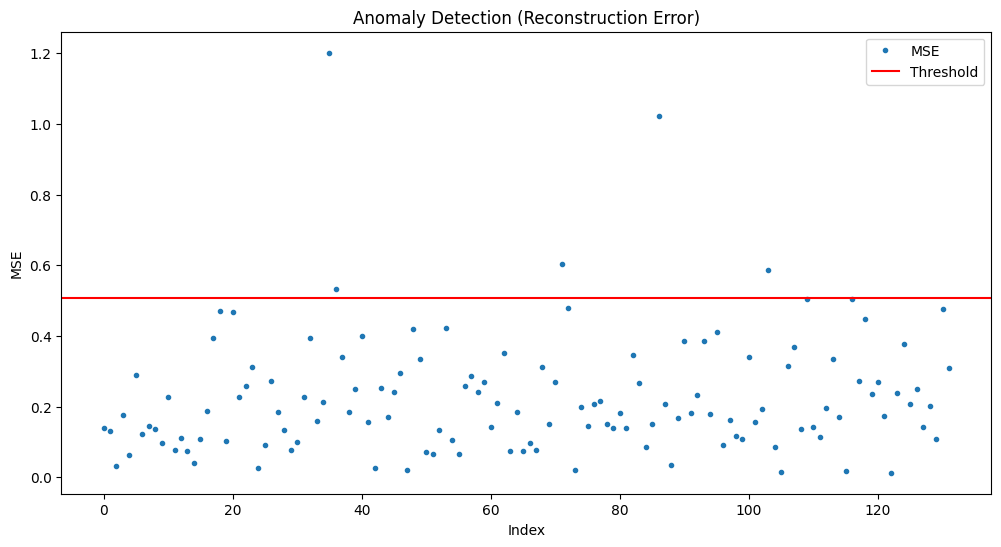

In [30]:
# 10. VISUALIZE MSE + THRESHOLD
# -------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(mse, label="MSE", marker='o', linestyle='', markersize=3)
plt.axhline(threshold, color='red', label='Threshold')
plt.title("Anomaly Detection (Reconstruction Error)")
plt.xlabel("Index")
plt.ylabel("MSE")
plt.legend()
plt.show()


In [32]:
# 11. CONFUSION MATRIX & METRICS
# -------------------------------------------------------
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, anomalies)
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, anomalies))

accuracy = accuracy_score(y_test, anomalies)
precision = precision_score(y_test, anomalies)
recall = recall_score(y_test, anomalies)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")



Confusion Matrix:
[[94  5]
 [33  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.95      0.83        99
           1       0.00      0.00      0.00        33

    accuracy                           0.71       132
   macro avg       0.37      0.47      0.42       132
weighted avg       0.56      0.71      0.62       132

Accuracy:  0.7121
Precision: 0.0000
Recall:    0.0000


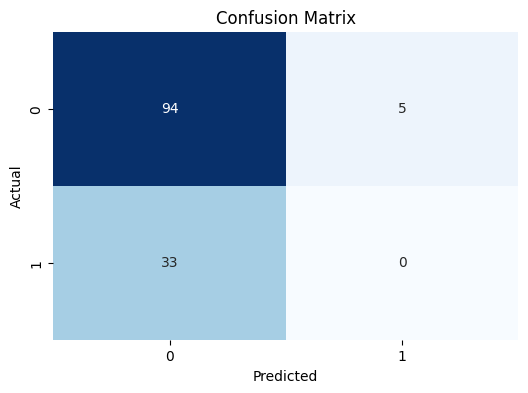

In [33]:
# 12. PLOT CONFUSION MATRIX
# -------------------------------------------------------
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()